# MAT5014 - Economic research - Suicide rates
*authors: BRAYE Valérien, CHHAY Ly An, ROLLAND Obed* <br>
*language: Python 3* <br>
*dataset: [Suicide Rates Overview 1985 to 2016](https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016), [Gender wadge gap](https://data.oecd.org/earnwage/gender-wage-gap.htm)*

## Imports and preliminary code
The following cell defines usefull global variables to configure this notebook.
- `DATAPATH`: change this to the path to the directory where the datasets are stored
- `SAVEFIGS`: weither to save the figures to disk or not. Saved figures will not have titles to be included in the report
- `FIGPATH`: path where the figures will be saved if `SAVEFIGS` is set to `True`
- `FIGPATH`: a seed used for all random procedures to make the results reproducible. Use current time if you want random results.

In [1]:
DATAPATH = "./data/"
SAVEFIGS = False
FIGPATH = "./report/figures/"
SEED = 42

This notebook uses `country_converter` to handle country codes. If it is not installed on your machine yet, simply run the following command in a terminal.
```bash
pip install country-converter
```

In [2]:
import itertools
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

warnings.filterwarnings("ignore")

The following cell defines a publication-ready `pyplot` theme, taken from [github](https://github.com/matplotlib/matplotlib/issues/19028).

In [3]:
plot_settings = {'ytick.labelsize': 16,
                 'xtick.labelsize': 16,
                 'font.size': 22,
                 'figure.figsize': (10, 5),
                 'axes.titlesize': 22,
                 'axes.labelsize': 18,
                 'lines.linewidth': 2,
                 'lines.markersize': 3,
                 'legend.fontsize': 11,
                 'mathtext.fontset': 'stix',
                 'font.family': 'STIXGeneral'}
plt.style.use(plot_settings)

The cell below defines usefull functions.

In [4]:
def sort_by_value(d: dict) -> dict:
    """
    Sorts a dict by its values (that must be "sortable")

    Args:
        d (dict)

    Returns:
        dict: d, sorted by value
    """
    return {k: v for k, v in sorted(d.items(), key=lambda x: x[1])}
        
def powerset(features: list[str]):
    """
    Args:
        features (list[str])

    Returns:
        a generator of the powerset of the list of features (e.g. ["a", "b"] -> ((), (a), (b), (a, b)))
    """
    return (list(comb)
            for k in range(len(features)+1)
            for comb in itertools.combinations(features, k))
    
def print_list(l: list, title: str = None, bullet: str = "•", max_items: int = None, randomize: bool = False, indent_level: int = 0) -> None:
    """
    Prints a list nicely. Handles sublists. Tupples will be displayed as items: ('e1', 'e2', ...).
    Parameters:
        • l: list to print
        • title: title of the list
        • bullet: bullet point to use
        • max_items: maximum number of items to print
        • randomize: pick random elements or not
        • indent_level: indentation level for sub-lists
    """
    if title:
        print(f"{indent_level * '  '}{title}:")
        indent_level += 1
    final_list_to_print = l.copy()
    if randomize:
        random.shuffle(final_list_to_print)
    if max_items:
        final_list_to_print = l[:max_items]
    for item in final_list_to_print:
        if isinstance(item, list):
            print_list(item, bullet=bullet, indent_level=indent_level+1)
        elif isinstance(item, tuple):
            print(f"{indent_level * '  '}{bullet} {str(item)}")
        else:
            print(f"{indent_level * '  '}{bullet} {item}")
    if len(final_list_to_print) != len(l):
        print(f"{indent_level * '  '}...")

## Exploratory Data Analysis
In this work, we use two datasets:
- [Suicide Rates Overview 1985 to 2016](https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016)
- [Gender wadge gap](https://data.oecd.org/earnwage/gender-wage-gap.htm)

The first one contains data about the number of suicides in many countries and different population categories between the years 1985 and 2016, while the second one gives, for different countries, the wadge gap that exists between male and female people.
First, we will explore the suicides dataset, then the gender wadge gap one, to finally try to link both dataset and find correlations in the data.

### Suicides dataset

In [5]:
suicides = pd.read_csv(DATAPATH + "suicides.csv")

In [6]:
print(f"Dataset dimensions: {suicides.shape[0]} × {suicides.shape[1]}")

Dataset dimensions: 27820 × 12


In [7]:
suicides.sample(5, random_state=SEED)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
17437,Netherlands,2015,male,5-14 years,1,987750,0.10,Netherlands2015,NaN,"757,999,453,314",47206,Generation Z
23991,Sri Lanka,2001,female,75+ years,31,222745,13.92,Sri Lanka2001,NaN,"15,749,753,805",912,Silent
8337,El Salvador,2013,female,35-54 years,19,748153,2.54,El Salvador2013,0.664,"21,977,401,900",3885,Generation X
21661,Saint Vincent and Grenadines,1987,female,75+ years,0,1500,0.00,Saint Vincent and Grenadines1987,NaN,"175,580,630",1908,G.I. Generation
6235,Costa Rica,2003,female,75+ years,0,54020,0.00,Costa Rica2003,NaN,"17,195,867,540",4583,Silent


In [8]:
suicides.sex.describe()

count     27820
unique        2
top        male
freq      13910
Name: sex, dtype: object

In [9]:
print_list(suicides.columns, "Variables in dataset")

Variables in dataset:
  • country
  • year
  • sex
  • age
  • suicides_no
  • population
  • suicides/100k pop
  • country-year
  • HDI for year
  •  gdp_for_year ($) 
  • gdp_per_capita ($)
  • generation


The dataset we will be using for this project has almost 30000 records of suicides that happened from 1985 to 2016, in 101 different countries all around the world. For each record 12 variables are given:
- `country`: the country of origin of the person
- `year`: year of the suicide
- `sex`: sex of the person (`"male"` or `"female"`)
- `age`: how old the person was, given as an interval
- `suicide_no`: number of suicides in the same country, sex, year and age group as the person 
- `population`: population size of the country, sex and age category of the person
- `suicides/100k pop`: number of suicides per 100000 people in the country
- `country-year`: concatenation of the country and the year
- `HDI for year`: human developement index of the year
- ` gdp_for_year ($)`: gross domestic product of the year, in dollars
- `gdp_per_capita ($)`: GDP of the year, per person, in dollar
- `generation`: generation of the person

### Data preparation for suicides dataset
In this section, we try to exclude outliers, remove `NaN`s and more generaly make the data easier to work with. We will also add the continent based on the country. <br>
First of all, some of the variable names used in the original dataset do not respect snake case, so we will rename them for ease of use.

In [10]:
columns_rename_map = {
    "suicides/100k pop": "suicides_rate",
    "country-year": "country_year",
    "HDI for year": "hdi",
    " gdp_for_year ($) ": "gdp",
    "gdp_per_capita ($)": "gdp_per_capita",
}

suicides.rename(columns_rename_map, axis=1, inplace=True);

We can also remove useless columns. Since they are redundant with the rest of the data, we will remove variables `country_year` and `generation`.

In [11]:
suicides.drop(["country_year", "generation"], axis=1, inplace=True)

To make it easier to manipulate the `age` variable, we will transform it according to the table below:
| Original `age` value | New `age` value |
| -------------------- | --------------- |
| `"5-14 years"`       | `0`             |
| `"15-24 years"`      | `1`             |
| `"25-34 years"`      | `2`             |
| `"35-54 years"`      | `3`             |
| `"55-74 years"`      | `4`             |
| `"75+ years"`        | `5`             |

Unfortunatly, not all age categories are of the same size: the last two are 20 years long while the first ones are 10 years long. It is necessary to keep this information in mind later in the study. To compensate for this issue, we will add two variables `age_min` and `age_max`, respectivly the minimum and maximum possible for the considered person. <br>
We will still keep the old `age` variable but rename it to `age_category`.

In [12]:
suicides["age_category"] = suicides.age

age_map = {
    "5-14 years": 0,
    "15-24 years": 1,
    "25-34 years": 2,
    "35-54 years": 3,
    "55-74 years": 4,
    "75+ years": 5
}

suicides.age = suicides.age.map(age_map)

suicides["age_min"] = suicides.age.map({
    0: 5,
    1: 15,
    2: 25,
    3: 35,
    4: 55,
    5: 75
})
suicides["age_max"] = suicides.age.map({
    0: 14,
    1: 24,
    2: 34,
    3: 54,
    4: 74,
    5: 94 # chosen to make the category 20 years long
})

Note that `gdp` is an object and not a float64 or an int. This is because it uses the american notation, separating 3 digit groups by commas. For instance, `2156624900` is represented by `2,156,624,900`. We will convert them to int in order to be able to manipulate them. 

In [13]:
suicides.gdp = suicides.gdp.apply(lambda x: int(x.replace(",", "")))

Next, we need to check for missing data.

In [14]:
for variable in suicides.columns:
    try:
        print(f"{suicides[variable].value_counts(normalize=True, dropna=False)[np.nan]*100:.1f}% of values are missing for variable {variable}.")
    except KeyError:
        print(f"No nan value for variable {variable}.")

No nan value for variable country.
No nan value for variable year.
No nan value for variable sex.
No nan value for variable age.
No nan value for variable suicides_no.
No nan value for variable population.
No nan value for variable suicides_rate.
69.9% of values are missing for variable hdi.
No nan value for variable gdp.
No nan value for variable gdp_per_capita.
No nan value for variable age_category.
No nan value for variable age_min.
No nan value for variable age_max.


There is no missing data except for the `hdi` variable, where more that two thirds of the values are missing. We could either:
- drop the observations with a missing value, which is not acceptable given the proportion of missing values.
- drop the `hdi` variable, but we suspect that it might be higly correlated to the number of suicides so it would be beneficial to keep it.
- fill as much as possible the missing values. This is the option we will take.

For each missing value, we will use the average `hdi` corresponding to the country. If there is not such record, we simply drop the observation.

In [15]:
def find_hdi(df: pd.DataFrame, country: str) -> int:
    """
    Return the average HDI of the country.
    If no record is found, returns -1.

    Args:
        df (pd.DataFrame): data
        country (str)
        year (int)

    Returns:
        int: HDI of country for year
    """
    records = df[df.country == country].dropna()
    if not records.empty:
        return records.hdi.mean()
    return -1

def fill_hdi_values(df: pd.DataFrame) -> int:
    """
    Fills missing values of the "hdi" variable of the provided dataframe.
    Missing values are filled using the average of existing values from the same country.

    Args:
        df (pd.DataFrame): data.

    Returns:
        int: number of missing values that were replaced.
    """
    memo = {} # stores, for each encountered country pair, the associated HDI
    replaced = 0
    for i, row in df.iterrows():
        if np.isnan(row["hdi"]):
            approx_hdi = -1
            if row["country"] in memo:
                approx_hdi = memo[row["country"]]
            else:
                approx_hdi = find_hdi(df, row["country"])
                memo[row["country"]] = approx_hdi
            if approx_hdi != -1:
                df.hdi[i] = approx_hdi
                replaced += 1
    return replaced

missing_hdi = suicides.hdi.value_counts(dropna=False)[np.nan]
filled_hdi = fill_hdi_values(suicides)
print(f"Filled {filled_hdi} ({filled_hdi/missing_hdi*100:.1f}%) of missing HDI values. About {suicides.hdi.value_counts(normalize=True, dropna=False)[np.nan]*100:.1f}% values are still missing.")
suicides.dropna(inplace=True)
print("All missing values have been droped.")

Filled 17970 (92.4%) of missing HDI values. About 5.3% values are still missing.
All missing values have been droped.


With this technique, we were able to go from 69% of missing values to about only 5%, that we droped.

### Data visualization of suicides dataset
Now that data preparation is done, we can explore it.
First of all, it would be great knowing the represented countries and how many years of records are provided for each of them.

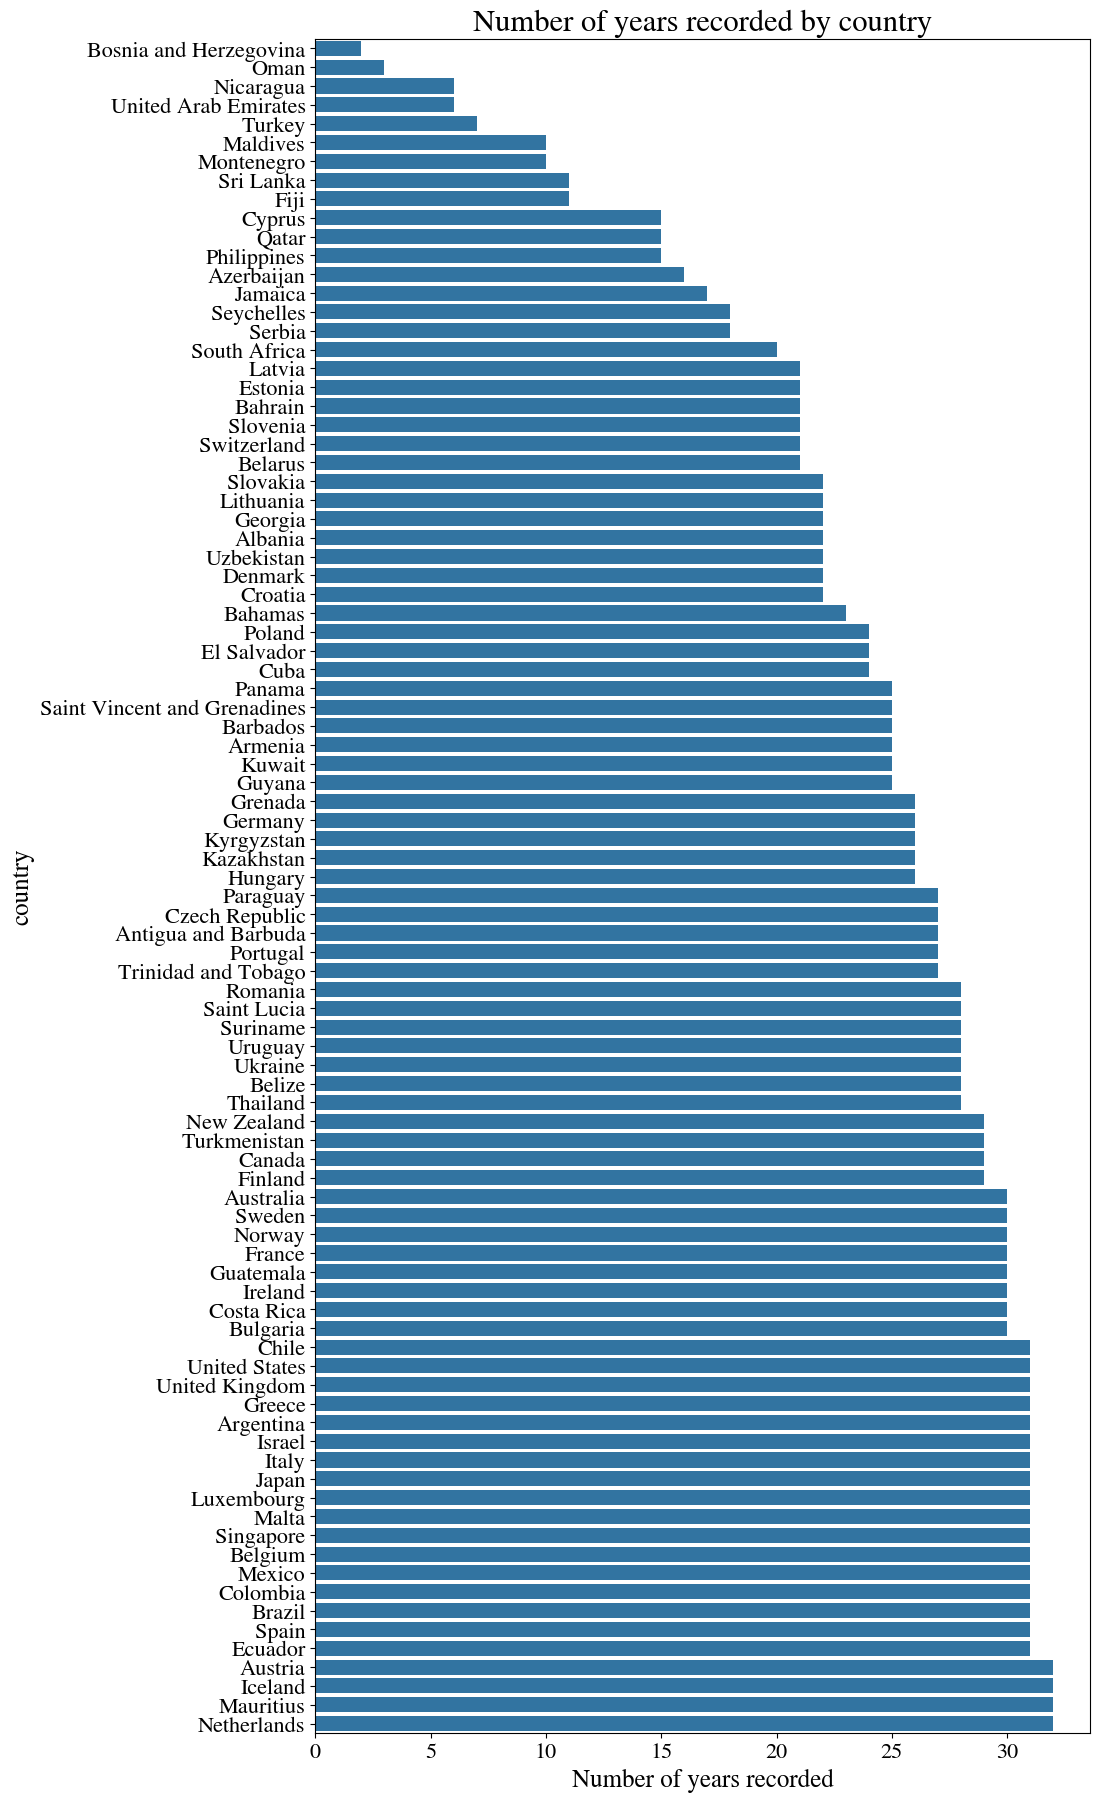

In [16]:
years_count = suicides.groupby("country").year.nunique().sort_values(ascending=True)
plt.figure(figsize=(10, 22))
sns.barplot(years_count, orient="h")
plt.xlabel("Number of years recorded")
plt.title("Number of years recorded by country");

Countries with the most records have about 30 years of data in the dataframe (so the whole time span of the study), but some other countries have only a few years recorded. However, most countries have at least 20 years recorded.

We can also examine the average suicide rate for each country.

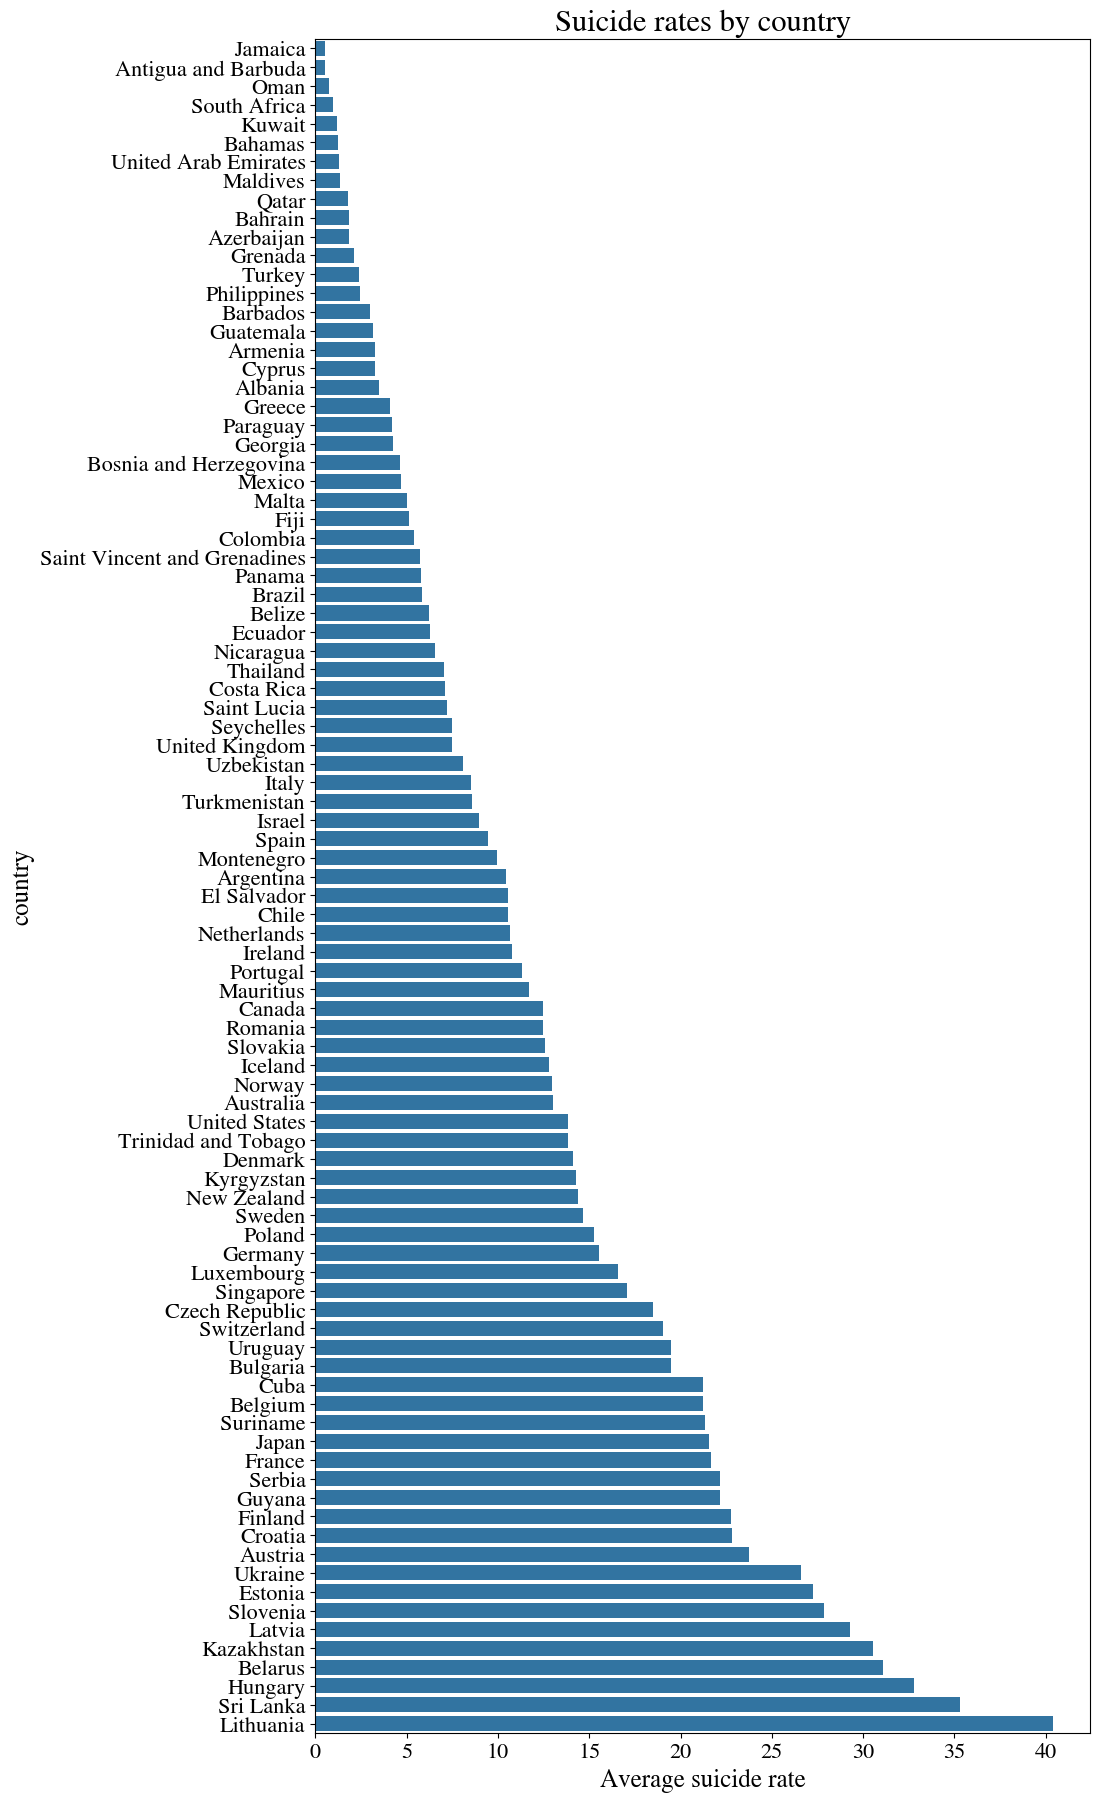

In [17]:
average_country_rates = suicides.groupby("country").suicides_rate.mean().sort_values()
plt.figure(figsize=(10, 22))
sns.barplot(average_country_rates, orient="h")
plt.xlabel("Average suicide rate")
plt.title("Suicide rates by country");

Let us now study the average suicide rate year.

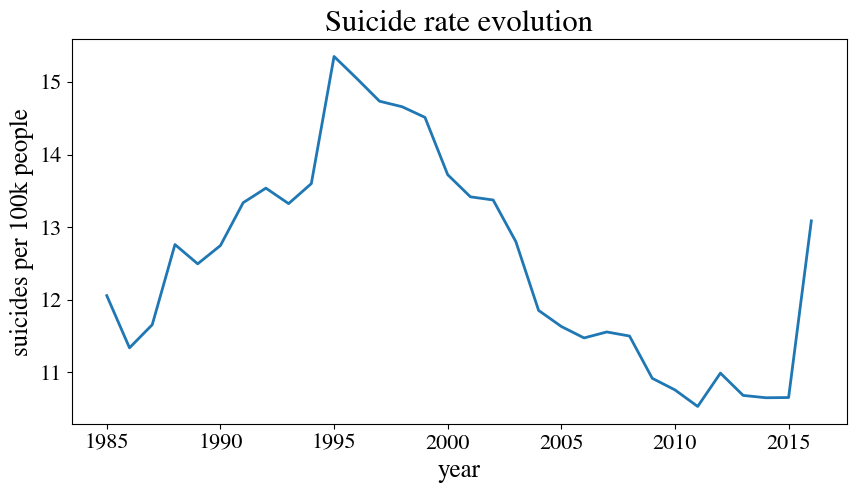

In [18]:
suicides_by_year = suicides.groupby("year").suicides_rate.mean()
sns.lineplot(suicides_by_year)
plt.xlabel("year")
plt.ylabel("suicides per 100k people")
plt.title("Suicide rate evolution");

Suicide rate went from about 12 suicides per 100k people in 1985 to a peak in 1995 at more than 15. This might seem strange at first glance but could actually be explained by the high level of mental distress an economical instability of the time ([see the events of 1995](https://en.wikipedia.org/wiki/1995#Events)). <br>
We can also study the number of suicides depending on some variables about the individuals such as sex or age category.

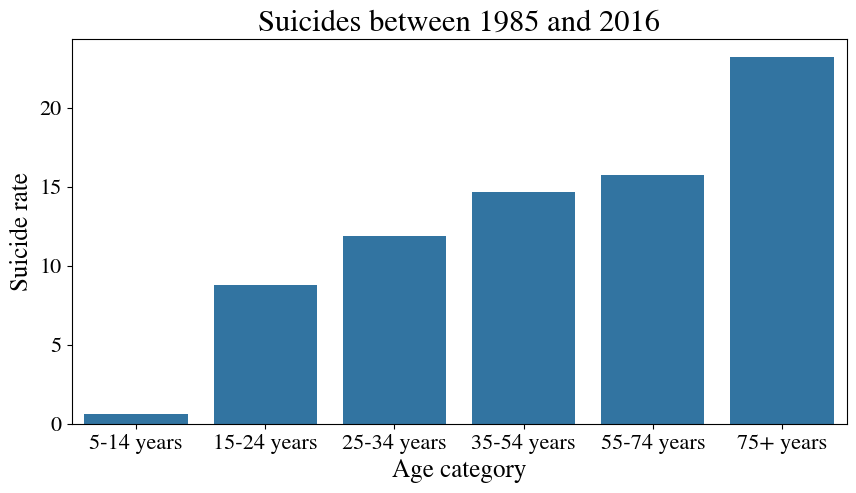

In [19]:
age_count = suicides.groupby("age").suicides_rate.mean()
sns.barplot(age_count)
plt.xticks(range(len(age_map)), labels=list(age_map.keys()))
plt.xlabel("Age category")
plt.ylabel("Suicide rate")
plt.title("Suicides between 1985 and 2016");

Most suicides occur when people are between 35 and 54 years, which could be explained by their work and the fact that they start getting older.

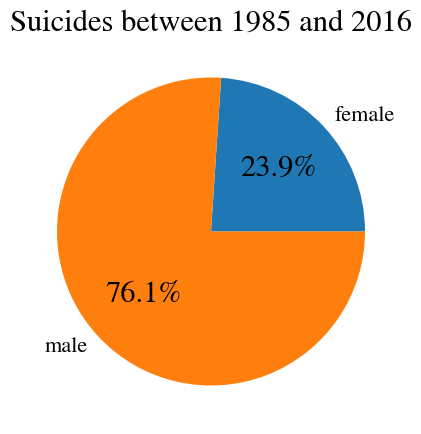

In [20]:
sex_count = suicides.groupby("sex").suicides_no.sum()
plt.pie(sex_count.values, labels=sex_count.index, autopct="%1.1f%%")
plt.title("Suicides between 1985 and 2016");

Most suicides are commited by men. In fact, most of the attempts are done by females, but they more rarely lead to death. Men tend to chose more violent and "effective" ways of commiting suicide and are less prone to seeking help ([source](https://en.wikipedia.org/wiki/Gender_differences_in_suicide)). <br>
Let us now focus on GPD and HDI.

In [21]:
suicides.gdp_per_capita

0         796
1         796
2         796
3         796
4         796
         ... 
27815    2309
27816    2309
27817    2309
27818    2309
27819    2309
Name: gdp_per_capita, Length: 26334, dtype: int64

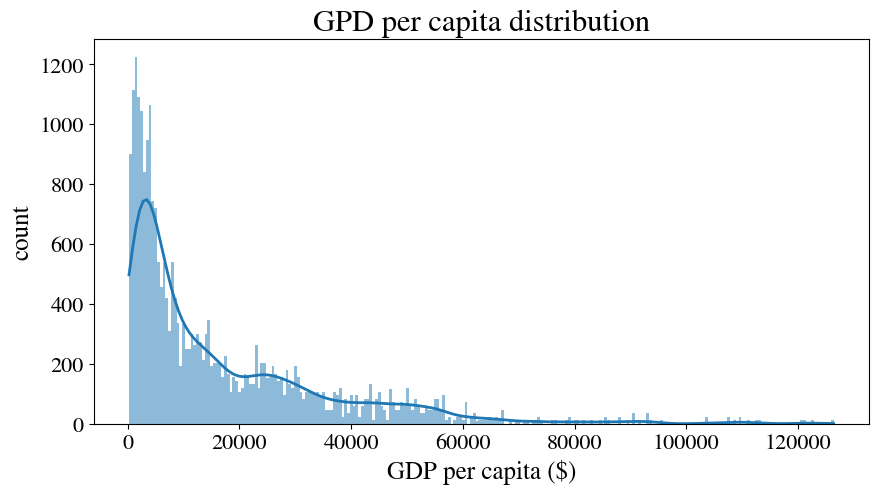

In [22]:
sns.histplot(suicides.gdp_per_capita, kde=True, binwidth=500, ec=None)
plt.title("GPD per capita distribution")
plt.xlabel("GDP per capita ($)")
plt.ylabel("count");

Whithout surprise, most countries have a low GPD per capita and only few of them have a high one.

Text(0, 0.5, 'HDI')

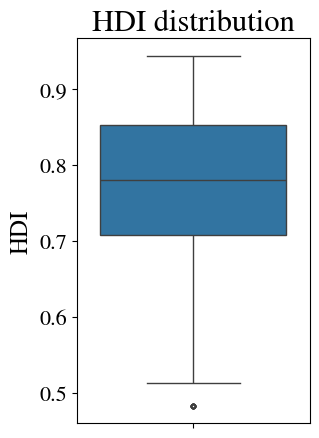

In [23]:
plt.figure(figsize=(3, 5))
sns.boxplot(suicides.hdi)
plt.title("HDI distribution")
plt.ylabel("HDI")

As we can seen, the HDI is contained between 0.5 and 1 and the average HDI is about 0.8. Let us try to corellate the GDP and the HDI to the suicide rate.

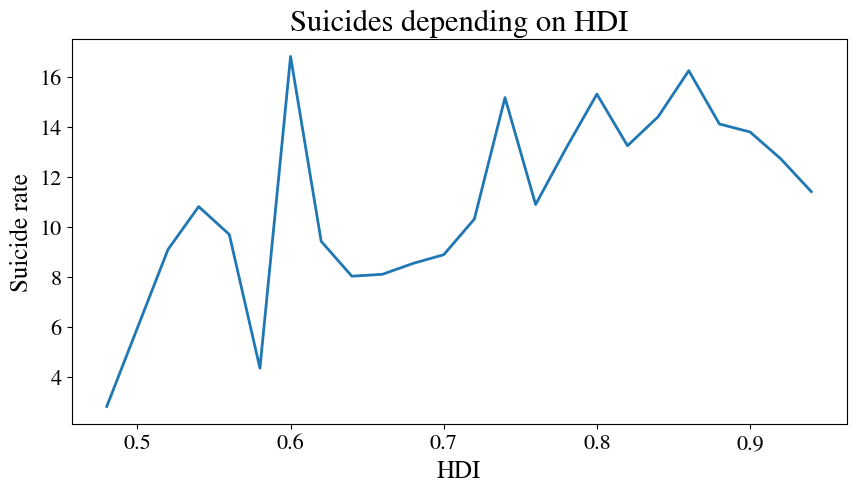

In [24]:
hdi_resolution = 50
suicides["hdi_category"] = suicides.hdi.map(lambda x: round(x*hdi_resolution)/hdi_resolution)
sns.lineplot(suicides.groupby("hdi_category").suicides_rate.mean())
plt.title("Suicides depending on HDI")
plt.xlabel("HDI")
plt.ylabel("Suicide rate");

Apparently, there is no linear relationship between the HDI and the suicide rate, as we could have expected. In fact, it even seems that the higher the HDI is, the higher the suicide rate tends to be, except a very high suicide rate for a HDI at about 0.6.

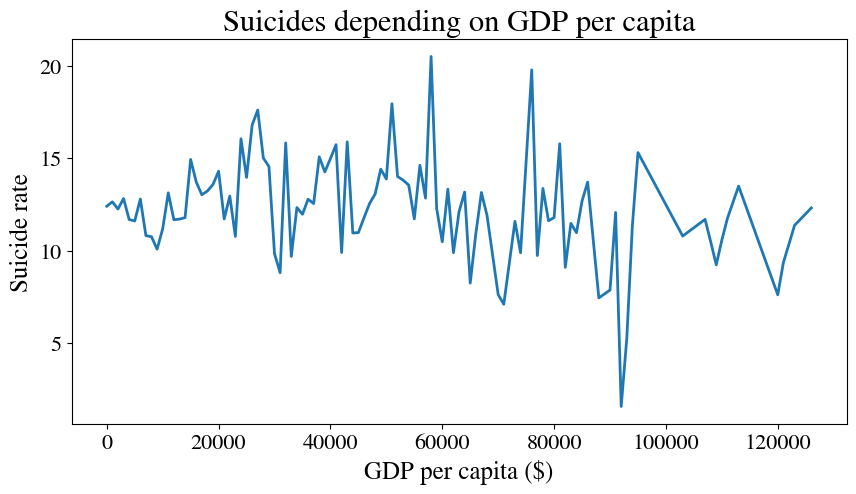

In [25]:
gdp_per_capita_resolution = .001
suicides["gdp_per_capita_category"] = suicides.gdp_per_capita.map(lambda x: round(x*gdp_per_capita_resolution)/gdp_per_capita_resolution)
sns.lineplot(suicides.groupby("gdp_per_capita_category").suicides_rate.mean())
plt.title("Suicides depending on GDP per capita")
plt.xlabel("GDP per capita ($)")
plt.ylabel("Suicide rate");

There is no clear relationship between the GDP per capita and the average suicide rate.

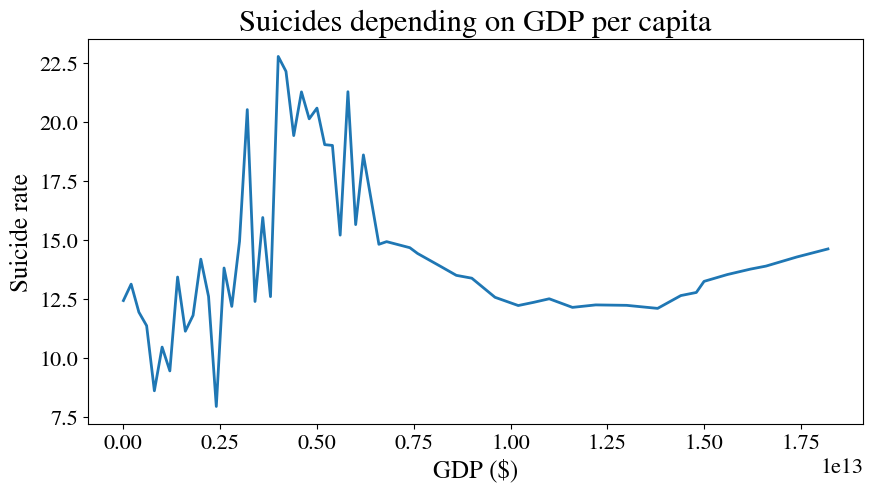

In [26]:
gdp_resolution = 0.000000000005
suicides["gdp_category"] = suicides.gdp.map(lambda x: round(x*gdp_resolution)/gdp_resolution)
sns.lineplot(suicides.groupby("gdp_category").suicides_rate.mean())
plt.title("Suicides depending on GDP per capita")
plt.xlabel("GDP ($)")
plt.ylabel("Suicide rate");

On the other hand, GDP seems to have a direct link with the suicide rate in the country. Very low GDP generaly lead to quite low suicide rate. Medium GDP countries record the highest suicide rates. And the suicide rates of high GDP countries are relatively average and stable. 

### Gender wadge gap

In [27]:
gender = pd.read_csv(DATAPATH + "gender_gap.csv")

In [28]:
print(f"Dataset dimensions: {gender.shape[0]} × {gender.shape[1]}")

Dataset dimensions: 1350 × 8


In [29]:
gender.sample(5, random_state=SEED)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
289,FIN,WAGEGAP,EMPLOYEE,PC,A,2002,20.373203,NaN
1036,USA,WAGEGAP,EMPLOYEE,PC,A,1978,38.972477,NaN
535,JPN,WAGEGAP,EMPLOYEE,PC,A,2003,31.997350,NaN
346,DEU,WAGEGAP,EMPLOYEE,PC,A,2003,19.820538,NaN
1075,USA,WAGEGAP,EMPLOYEE,PC,A,2017,18.172157,NaN


In [30]:
print_list(gender.columns, "Variables in dataset")

Variables in dataset:
  • LOCATION
  • INDICATOR
  • SUBJECT
  • MEASURE
  • FREQUENCY
  • TIME
  • Value
  • Flag Codes


The dataset we will be using for this project has almost 30000 records of suicides that happened from 1985 to 2016, in 101 different countries all around the world. For each record 12 variables are given:
- `LOCATION`: the country code
- `INDICATOR`: always `"WADGEGAP"`, useless variable that we remove during data preparation.
- `SUBJECT`: `"EMPLOYEE"` or `"SELFEMPLOYED"`
- `MEASURE`: always `"PC"`, useless variable that we remove during data preparation.
- `TIME`: year of the record, between 1970 and 2022. 
- `FREQUENCY`: always `"A"`, useless variable that we remove during data preparation.
- `Value`: gender wadge gap, in percents. 
- `Flag Codes`: always `NaN` or `B`, useless variable that we remove during data preparation.

### Data preparation for gender gap
In this section, we try to exclude useless variables and outliers, remove `NaN`s and more generaly make the data easier to work with. <br>
First of all, some of the variable names used in the original dataset do not respect snake case, so we will rename them for ease of use.

In [31]:
columns_rename_map = {
    "LOCATION": "country",
    "SUBJECT": "employment",
    "TIME": "year",
    "Value": "gap",
}

gender.rename(columns_rename_map, axis=1, inplace=True);

Now we can drop useless columns.

In [32]:
gender.drop(["INDICATOR", "MEASURE", "FREQUENCY", "Flag Codes"], axis=1, inplace=True)

As shown by the following cell, there is no missing data in the resulting dataset.

In [33]:
for variable in gender.columns:
    try:
        print(f"{gender[variable].value_counts(normalize=True, dropna=False)[np.nan]*100:.1f}% of values are missing for variable {variable}.")
    except KeyError:
        print(f"No nan value for variable {variable}.")

No nan value for variable country.
No nan value for variable employment.
No nan value for variable year.
No nan value for variable gap.


Next, the countries are identified by their code. To be able to work with the suicides dataset, we need to convert these codes to the full country names. We could have used python libraries such as `country_converter` or `pycountry`, but due to the small number of convertions we need to do, it would be inefficient to install such libraries. We will instead use a simple mapping, constructed by hand.

In [34]:
country_code_to_name = {
    "AUS": "Australia",
    "AUT": "Austria",
    "BEL": "Belgium",
    "CAN": "Canada",
    "CZE": "Czech Republic",
    "DNK": "Danemark",
    "FIN": "Finland",
    "FRA": "France",
    "DEU": "Germany",
    "GRC": "Greece",
    "HUN": "Hungary",
    "ISL": "Iceland",
    "IRL": "Ireland",
    "ITA": "Italia",
    "JPN": "Japan",
    "KOR": "Korea",
    "LUX": "Luxembourg",
    "MEX": "Mexico",
    "NLD": "Netherlands",
    "NZL": "New Zealand",
    "NOR": "Norway",
    "POL": "Poland",
    "PRT": "Portugal",
    "SVK": "Slovakia",
    "ESP": "Spain",
    "SWE": "Sweden",
    "CHE": "Switzerland",
    "TUR": "Turkey",
    "GBR": "United Kingdom",
    "USA": "United States",
    "BGR": "Bulgaria",
    "CHL": "Chile",
    "COL": "Colombia",
    "CRI": "Costa Rica",
    "HRV": "Croatia",
    "CYP": "Cyprus",
    "EST": "Estonia",
    "ISR": "Israel",
    "LVA": "Latvia",
    "LTU": "Lithuania",
    "MLT": "Malta",
    "ROU": "Romania",
    "SVN": "Slovenia",
    "OECD": "International", # Not a country
    "EU27": "European Union", # Not a country
    "ARG": "Argentina",
    "BRA": "Brazil",
}
gender["country"] = gender.country.map(country_code_to_name)

### Data visualization of gender gap dataset
One of the first things we can plot is the average wadge gap per year and try to detect a trend.

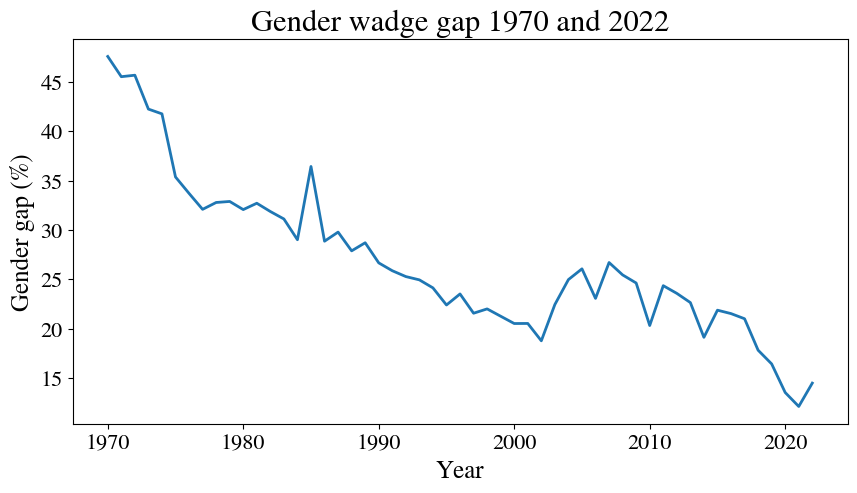

In [35]:
gap_by_year = gender.groupby("year").gap.mean()
sns.lineplot(gap_by_year)
plt.xlabel("Year")
plt.ylabel("Gender gap (%)")
plt.title("Gender wadge gap 1970 and 2022");

As we could have expected, the gender wadge gap has highly decreased in the past decades. Surpisingly, we note that it increased between 2002 and 2005, but kept decreasing after that. <br>
Now we can also visualize the average gender gap depending on the country since 1970.

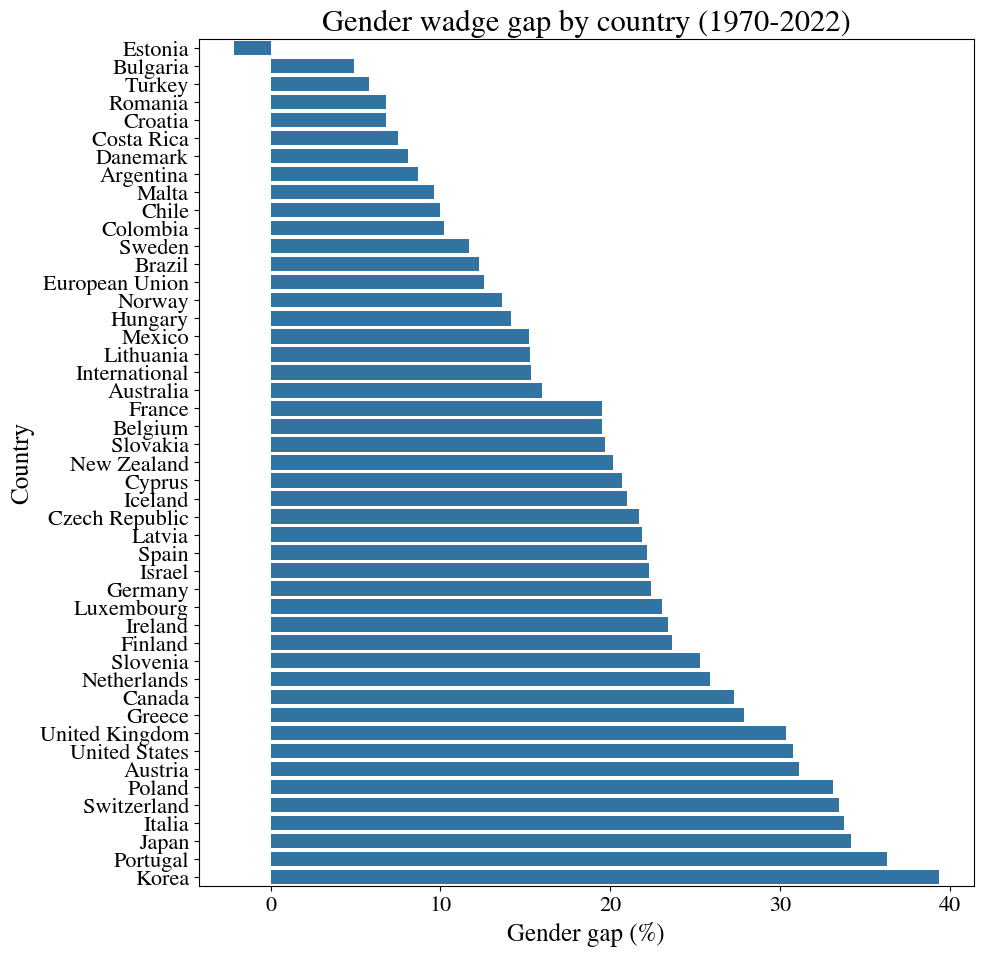

In [36]:
average_country_gap = gender.groupby("country").gap.mean().sort_values()
plt.figure(figsize=(10, 11))
sns.barplot(average_country_gap, orient="h")
plt.xlabel("Gender gap (%)")
plt.ylabel("Country")
plt.title("Gender wadge gap by country (1970-2022)");

Countries with the bigest country gap are:
- Korea
- Portugal
- Japan

And the lowest gaps are found in:
- Estonia
- Bulgaria
- Turkey

As we can see from these first results, the country developement is not directly responsible for the gender wadge gap in that country. The lowest gender gap is met in Estonia, where it even is negative (on average, women earn more than men). Estonia is the only country that has a negative average gender gap, that is that in all other countries, men tend to earn more than women. <br>
We can also note that the European Union (denoted by `EU27`) has a gender gap slighly below the average. <br>
But this is the average gender gap since 1970 and might not be representative of the recent data. We will plot the same data, but restrict the year between 2017 and 2022 in order to get a better representation of what the gender gap is currently.

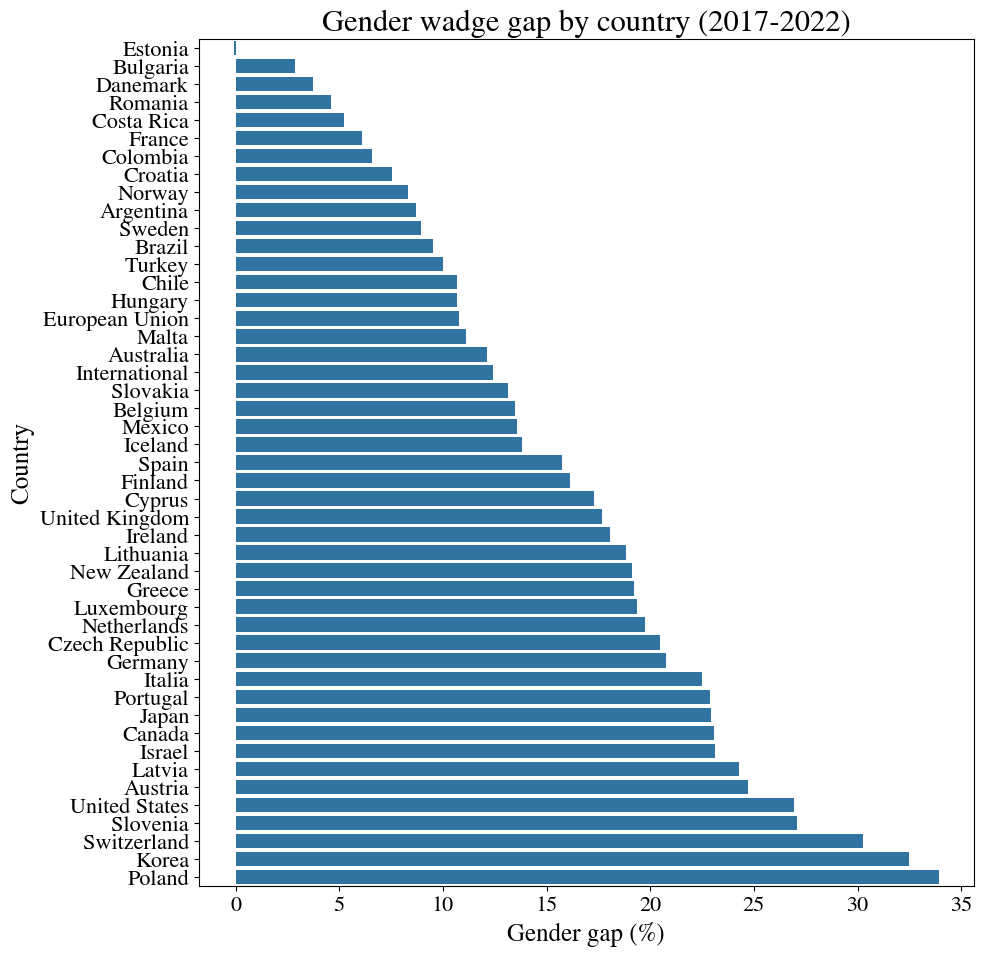

In [37]:
recent_average_country_gap = gender[gender.year>=2017].groupby("country").gap.mean().sort_values()
plt.figure(figsize=(10, 11))
sns.barplot(recent_average_country_gap, orient="h")
plt.xlabel("Gender gap (%)")
plt.ylabel("Country")
plt.title("Gender wadge gap by country (2017-2022)");

This does not have a really big impact on the data, except that now most countries with a low gender wadge gap are european. The country with the bigest gender gap is now Poland, but Korea still has a very high gender gap. <br>
Note that the gender gap is globaly lower in the last 5 years than since 1970, which is confirmed by the first plot of this section. <br>
Another interesting variable to take in acount is the type of employement. We expect self-employed people to met a lower gender wadge gap since they are paying themselves, but we can verify this hypothesis with the following chart.

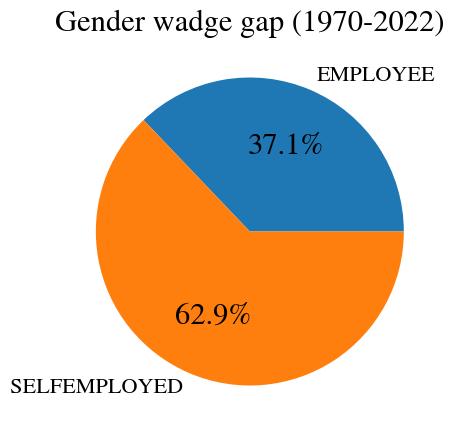

In [38]:
employement_gap = gender.groupby("employment").gap.mean()
plt.pie(employement_gap.values, labels=employement_gap.index, autopct="%1.1f%%")
plt.title("Gender wadge gap (1970-2022)");

Strangely, self-employed people face a higher gender gap than employed people. This is becaused most self-employed women tend to charge less than self-employed men, leading to a lower wadge and most self-employed workers are small companies ([source](https://theconversation.com/gender-pay-gap-is-bigger-for-some-women-than-others-heres-how-to-work-it-out-199473)).

### Preparation of the full dataframe
In this section, we combine both datasets in a single dataframe, that we will later use in our model. <br>
The decision has been made to group data by year and by country. Since the data changes a lot through time (especialy the gender wadge gap) and geography, this ensures we keep important variables in our data, but ignore factors that might introduce too much complexity and less revelant information. <br>
We also need to choose the variables we will keep in this final dataframe. Given our previous analysis and our goal, we choose to keep the following variables:
- `year`
- `country`
- `suicides_rate` (the average suicide rate)
- `gdp`
- `gdp_per_capita`
- `hdi`
- `gap` (the gender wadge gap)

Note that some country included in the suicide rates dataset are not present in the gender wadge gap dataset. We will ignore those countries in the rest of our study, keeping the 47 countries already included in the gender gap dataset, which is already enough for our analysis.

In [39]:
left = pd.DataFrame() # left dataframe for the following join operation
left["suicides_rate"] = suicides.groupby(["year", "country"]).suicides_rate.mean()
left["gdp"] = suicides.groupby(["year", "country"]).gdp.mean()
left["gdp_per_capita"] = suicides.groupby(["year", "country"]).gdp_per_capita.mean()
left["hdi"] = suicides.groupby(["year", "country"]).hdi.mean()
left = left.reset_index()
left

right = pd.DataFrame() # right dataframe for the following join operation
right = gender.groupby(["year", "country"]).gap.mean()

data = pd.merge(
    left,
    right, 
    "inner",
    ["year", "country"]
)

In [40]:
print(f"Data shape: {data.shape[0]}×{data.shape[1]}")
data.sample(5, random_state=SEED)

Data shape: 604×7


,year,country,suicides_rate,gdp,gdp_per_capita,hdi,gap
110,1999,Canada,13.203333,6.760827e+11,23572.0,0.881111,24.000000
452,2011,Netherlands,9.423333,8.937573e+11,56667.0,0.919000,27.785742
568,2014,United States,14.277500,1.742761e+13,58531.0,0.915000,33.008331
77,1996,Japan,19.040000,4.833713e+12,40693.0,0.861300,36.847323
181,2002,Spain,9.636667,7.051459e+11,17924.0,0.831700,17.161961


The clean data frame we built (`data`) can now be used in for modelization. For each year and country, it contains the average suicide rate, GDP, GDP per capita, HDI and gender wadge gap for each year and country (604 rows), providing 6 descriptive features to predict the interest variable, `suicides_rate`.

### Data visualization of suicides vs gender gap
In this section, we try to visualy detect some correlation between the gender gap present in different countries and the suicide rates in these countries. <br>
Firstly, we will plot the average suicide rate by year depending on the average gender wadge gap.

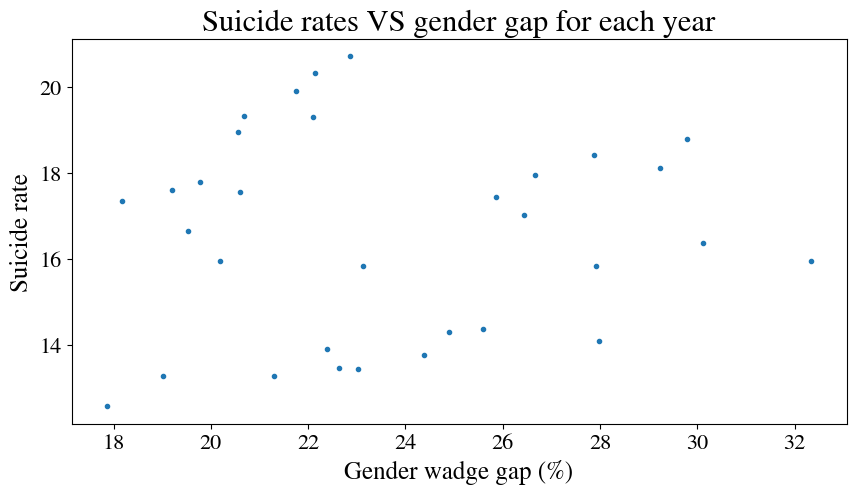

In [41]:
plt.scatter(data.groupby("year").gap.mean(), data.groupby("year").suicides_rate.mean())
plt.title("Suicide rates VS gender gap for each year")
plt.xlabel("Gender wadge gap (%)")
plt.ylabel("Suicide rate");

Next, we will take a look at the relationship between the gender gap and the suicide rates by country. Note that this is possible since we renamed the countries in the gender gap dataset.

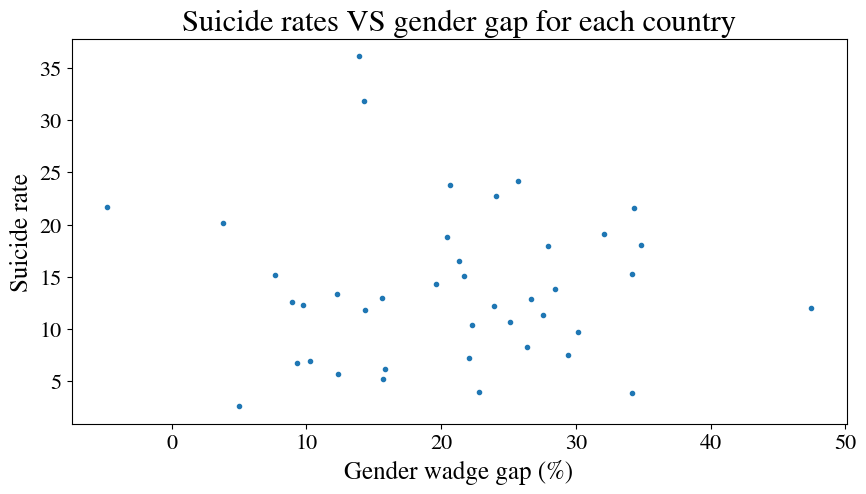

In [42]:
plt.scatter(data.groupby("country").gap.mean(), data.groupby("country").suicides_rate.mean())
plt.title("Suicide rates VS gender gap for each country")
plt.xlabel("Gender wadge gap (%)")
plt.ylabel("Suicide rate");

## Modeling
In this section, we use the data we prepared and visualized in the previous section to build a model allowing us to describe the suicide rates depending on variables such as country, year but also economical data such as GDP or gender wadge gap. <br>
We start by spliting the data into a training and a testing set and then build models on our data. For each model, we fit it to the data and the evaluate its performance. Then we try to conclude on the best model for this task, and fit it on the whole dataset.

### Train / test split
In order to train a model and evaluate its performance, we need at least two datasets:
- a training set (`train`), that is used to fit the model (compute the parameters of the model)
- a testing set (`test`), that is not used to fit the model, only to measure its quality. This ensures the model is evaluated on unknown data.

In this work, we have a relativly small/medium sized dataset (604 observations). In order to get good quality evaluation, we choose to keep a relatively high number of rows for the testing set, i.e. 30%. <br>
We also make a distinction between the features, denoted as `X` in the rest of this notebook and the variable of interest (`suicides_rate`), denoted as `y`.

In [43]:
features = ["year", "gdp", "gdp_per_capita", "hdi", "gap"]

X_train, X_test, y_train, y_test = train_test_split(data[features], data.suicides_rate, test_size=.3, random_state=SEED)

print("Number of observations:")
print(f"   - train: {X_train.shape[0]} ({X_train.shape[0]/data.shape[0]*100:.0f}%)")
print(f"   - test: {X_test.shape[0]} ({X_test.shape[0]/data.shape[0]*100:.0f}%)")

Number of observations:
   - train: 422 (70%)
   - test: 182 (30%)


### Univariate linear regression
The first class of models that we will try to use are simple univariate linear regressions. For each of the five numerical features we are taking in acount (we exclude country), we will create a linear regression model trying to estimate the suicide rate depending on this variable. We will then retain the model minimizing the mean squared error (MSE) on the test set: it will be the best univariate linear regression model.  

In [44]:
def apply_lr(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series) -> tuple[LinearRegression, float]:
    """
    Applies linear regression to the provided train data and returns the model and its MSE on the test data.

    Args:
        X_train (pd.DataFrame)
        y_train (pd.Series)
        X_test (pd.DataFrame)
        y_test (pd.Series)

    Returns:
        tuple[LinearRegression, float]
    """
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_predictions = lr.predict(X_test)
    lr_test_mse = mean_squared_error(y_test, lr_predictions)
    return lr, lr_test_mse

In [45]:
for feature in features:
    if feature != "country":
        model, mse = apply_lr(X_train[feature].values.reshape(-1, 1), y_train, X_test[feature].values.reshape(-1, 1), y_test)
        print(f"MSE for feature {feature}: {mse:.2f}")

MSE for feature year: 43.91
MSE for feature gdp: 45.43
MSE for feature gdp_per_capita: 44.26
MSE for feature hdi: 46.33
MSE for feature gap: 43.94


As we can see from the output above, the best univariate linear regression model is the one estimating the suicide rates based on time (`year` variable), with an MSE of 43.91. Let us now visualize how the model fits the data. 

In [46]:
univariate_regression = LinearRegression().fit(X_train.year.values.reshape(-1, 1), y_train)
univariate_regression_predictions = univariate_regression.predict(X_test.year.values.reshape(-1, 1))

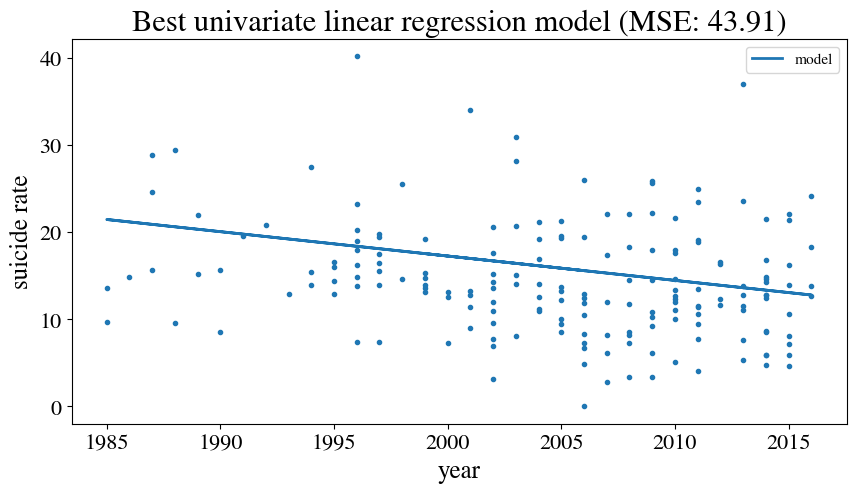

In [47]:
title = f"Best univariate linear regression model (MSE: {mean_squared_error(y_test, univariate_regression_predictions):.2f})"
plt.scatter(X_test.year, y_test)
plt.plot(X_test.year, univariate_regression_predictions, label="model")
plt.title(title)
plt.xlabel("year")
plt.ylabel("suicide rate")
plt.legend();

As we can see, this model tries to fit the data the best, but simply cannot due to the lack of information. We need to consider more variables, which will greatly improve the quality of the model as we will show in the following section.

### Multivariate linear regression
Since considering a single variable is not enough, we use multiple variables to perform better linear regressions in this sections. <br>
Instead of considering all variables, which might lead to over-fitting depending on our data, we will perform feature selection. This process is usually done through forward or backward feature selection to avoid testing all feature combinations, but since we only consider five numerical features, there only are $25 = 5^2$ models to consider in total which is reasonable. <br>

In [48]:
def lr_feature_selection(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series) -> dict:
    """
    Use MSE to give the best features to use in a linear regression model.

    Args:
        X_train (pd.DataFrame)
        y_train (pd.Series)
        X_test (pd.DataFrame)
        y_test (pd.Series)

    Returns:
        dict: a dict where the keys are tuples of selected variables (their names) and the values are the associated MSE. Sorted in ascending MSE order (first element is the best model)
    """
    features = list(X_train.columns)
    mse =  {} # stores the aic associated to each feature selection
    for selected_features in powerset(features):
        if selected_features: # ignores the empty list
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]
            _, model_mse = apply_lr(X_train_selected, y_train, X_test_selected, y_test)
            mse[tuple(selected_features)] = model_mse
    return sort_by_value(mse)

In [49]:
sorted_mse = lr_feature_selection(X_train[["year", "gdp", "gdp_per_capita", "hdi", "gap"]], y_train, X_test[["year", "gdp", "gdp_per_capita", "hdi", "gap"]], y_test)
best_features = list(sorted_mse.keys())[0]
best_mse = sorted_mse[best_features]
best_features = list(best_features)

print(f"Best MSE: {best_mse:.2f}")
print_list(best_features, f"Obtained with {len(best_features)} features")

Best MSE: 43.25
Obtained with 3 features:
  • gdp_per_capita
  • hdi
  • gap


The best multivariate linear regression model is thus the one taking in account the three variables `gdp_per_capita`, `hdi` and `gap`, which intuitively makes sense. However, the MSE improvement over the univariate is very small. Indeed, the MSE of the multivariate model is 43.25, against 43.91 for the best univariate linear regression model. <br>
This shows the need to introduce a model which will better fit our data. Due to its nature, we will try to explore the decision tree model in the next section.

### Decision tree regressor
In this section, we apply the decision tree regressor model to our data in an attempt at improving the test MSE.

In [50]:
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
decision_tree_predictions = decision_tree.predict(X_test)
decision_tree_test_mse = mean_squared_error(y_test, decision_tree_predictions)
print(f"Decision tree regressor MSE: {decision_tree_test_mse:.2f}")

Decision tree regressor MSE: 37.38


Using a decision tree for our regression task improved the test MSE. But a random forest might improve the test MSE even more, that is the model we will try to apply in the next section.

### Random forest regression
After using a decision tree that performed quite well, the only logical step is to try using a random forest on our data. Due to the relatively low number of observations in our training set, we decided using only using 30 trees in the random forest. We will also restrict the maximum tree depth to 12 to avoid over-fitting, which is frequent with this kind of models.

In [51]:
random_forest = RandomForestRegressor(
    n_estimators=30,
    max_depth=12
)
random_forest.fit(X_train, y_train)
random_forest_predictions = random_forest.predict(X_test)
random_forest_test_mse = mean_squared_error(y_test, random_forest_predictions)
print(f"Random forest regressor MSE: {random_forest_test_mse:.2f}")

Random forest regressor MSE: 14.77


As we can see, using a random forest greatly reduces the MSE on the testing set, yielding the best test MSE yet, 14.67, against about 40 for all the models we have tried before. A great asset of random forest is that they allow us to see which features had the most impact during training.

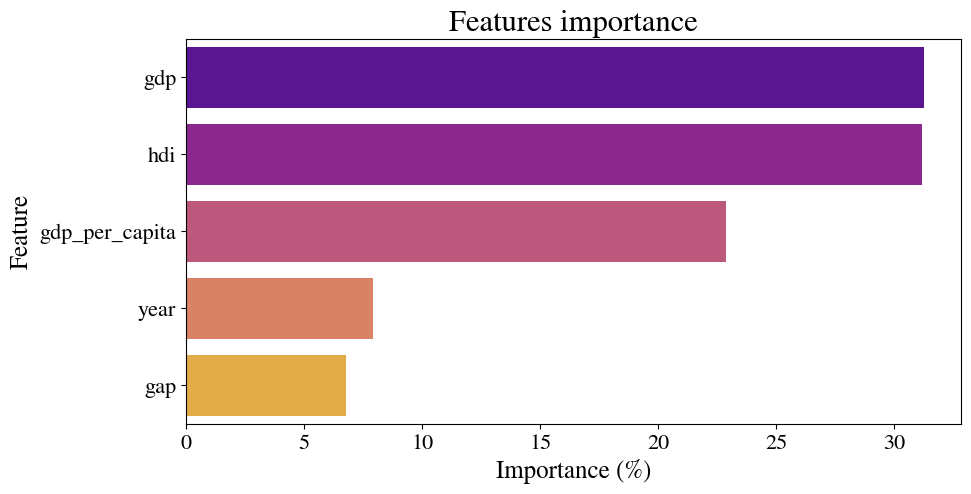

In [52]:
feature_importances = random_forest.feature_importances_
feature_importance_dict = {features[i]: feature_importances[i] for i in range(len(features))}
importance_df = pd.DataFrame(list(feature_importance_dict.items()), columns=["Feature", "Importance"])
importance_df["Importance"] = importance_df.Importance*100
importance_df = importance_df.sort_values(by="Importance", ascending=False)
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="plasma")
plt.title("Features importance")
plt.xlabel("Importance (%)")
plt.ylabel("Feature")
plt.show()

Our random forest thus gives the most importance to the three following features:
- `gdp`
- `hdi`
- `gdp_per_capita`

While the two remaining features, `year` and `gap`, only have less the 15% of importance combined.

### Conclusion on the different models
The test MSE scores can be summarized in the following table:
| Model                          | Test MSE |
| ------------------------------ | -------- |
| Univariate linear regression   | 43.91    |
| Multivariate linear regression | 43.25    |
| Decision tree regressor        | 37.03    |
| Random forest regressor        | 14.67    |
